# Westchester County Parcel Building Analysis

This notebook analyzes Westchester County tax parcels and cross-references them with building databases to determine the number of buildings within each parcel. 

## Objectives:
1. Load and explore parcel data from CSV and shapefile
2. Access building footprint databases (Microsoft Buildings, OpenStreetMap)
3. Perform spatial analysis to count buildings per parcel
4. Create visualizations and export results

## Data Sources:
- **Parcel Data**: Westchester County tax parcels (CSV + Shapefile)
- **Building Data**: Microsoft Building Footprints, OpenStreetMap buildings
- **Analysis Period**: Current assessment data

## 1. Import Required Libraries

In [1]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pyproj
from pyproj import CRS

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import plotly.express as px
import plotly.graph_objects as go

# API access for building data
import requests
import json
import overpy  # For OpenStreetMap data
from urllib.parse import urlencode

# File handling and OS operations
import os
import zipfile
from pathlib import Path

# Statistics and spatial analysis
from scipy import stats
import contextily as ctx  # For basemaps

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"GeoPandas version: {gpd.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
Pandas version: 2.3.2
GeoPandas version: 1.1.1
NumPy version: 2.3.3


## 2. Load Parcel Data

In [2]:
# Define data paths
DATA_DIR = Path("../datasets")
PARCELS_SHP = DATA_DIR / "Westchester_County_Parcels" / "Westchester_Parcels.shp"
PARCELS_CSV = DATA_DIR / "Westchester_County_Parcels_3053716610941103405.csv"

print(f"Data directory: {DATA_DIR}")
print(f"Shapefile exists: {PARCELS_SHP.exists()}")
print(f"CSV exists: {PARCELS_CSV.exists()}")

# Load the shapefile (preferred for spatial analysis)
try:
    print("\nLoading shapefile...")
    parcels_gdf = gpd.read_file(PARCELS_SHP)
    print(f"Successfully loaded {len(parcels_gdf):,} parcels from shapefile")
    print(f"CRS: {parcels_gdf.crs}")
    print(f"Bounds: {parcels_gdf.total_bounds}")
    
    # Display basic info about the shapefile
    print(f"\nShapefile columns: {list(parcels_gdf.columns)}")
    print(f"Geometry type: {parcels_gdf.geometry.geom_type.unique()}")
    
except Exception as e:
    print(f"Error loading shapefile: {e}")
    parcels_gdf = None

Data directory: ..\datasets
Shapefile exists: True
CSV exists: True

Loading shapefile...
Successfully loaded 257,530 parcels from shapefile
CRS: EPSG:3857
Bounds: [-8235431.3013  4994210.9566 -8179952.5831  5066525.9813]

Shapefile columns: ['COUNTY_NAM', 'MUNI_NAME', 'SWIS', 'PARCEL_ADD', 'PRINT_KEY', 'SBL', 'CITYTOWN_N', 'CITYTOWN_S', 'LOC_ST_NBR', 'LOC_STREET', 'LOC_UNIT', 'LOC_ZIP', 'PROP_CLASS', 'ROLL_SECTI', 'LAND_AV', 'TOTAL_AV', 'FULL_MARKE', 'YR_BLT', 'FRONT', 'DEPTH', 'SQ_FT', 'ACRES', 'SCHOOL_COD', 'SCHOOL_NAM', 'SEWER_TYPE', 'SEWER_DESC', 'WATER_SUPP', 'WATER_DESC', 'UTILITIES', 'UTILITIES_', 'BLDG_STYLE', 'BLDG_STY_1', 'HEAT_TYPE', 'HEAT_TYPE_', 'FUEL_TYPE', 'FUEL_TYPE_', 'SQFT_LIVIN', 'GFA', 'NBR_KITCHE', 'NBR_FULL_B', 'NBR_BEDROO', 'USED_AS_CO', 'USED_AS_DE', 'AG_DIST_CO', 'AG_DIST_NA', 'PRIMARY_OW', 'MAIL_ADDR', 'PO_BOX', 'MAIL_CITY', 'MAIL_STATE', 'MAIL_ZIP', 'ADD_OWNER', 'ADD_MAIL_A', 'ADD_MAIL_P', 'ADD_MAIL_C', 'ADD_MAIL_S', 'ADD_MAIL_Z', 'BOOK', 'PAGE', 'GRID_EAST'

### filter for Bedford only

In [6]:
parcels_gdf = parcels_gdf.loc[parcels_gdf.MUNI_NAME == 'Bedford']

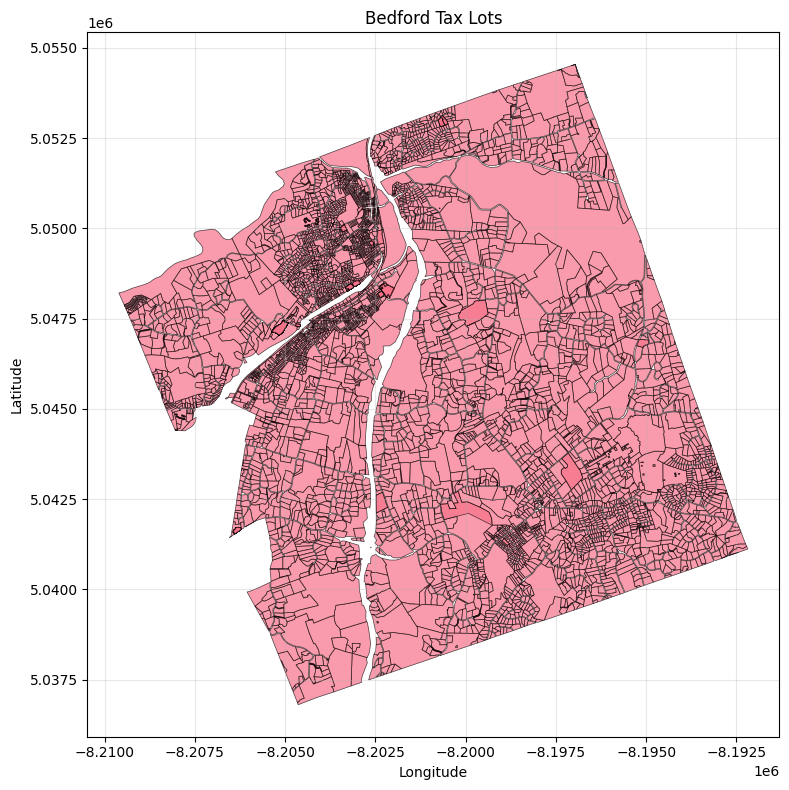


Converting from EPSG:3857 to WGS84...
Conversion complete

WGS84 bounds: [-73.74815136  41.16565413 -73.59163084  41.28549615]


In [16]:
# Examine the parcel data structure
if parcels_gdf is not None:
    # print("Parcel Data Sample:")
    # print(parcels_gdf.head())
    
    # print(f"\nData types:")
    # print(parcels_gdf.dtypes)
    
    # print(f"\nData summary:")
    # print(parcels_gdf.describe())
    
    # Check for missing values
    # print(f"\nMissing values:")
    # print(parcels_gdf.isnull().sum())
    
#     # Plot sample parcels
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
#     # Plot a sample of parcels (first 1000 for performance)
    sample_parcels = parcels_gdf.head(1000)
    parcels_gdf.plot(ax=ax, alpha=0.7, edgecolor='black', linewidth=0.5)
    
    plt.title("Bedford Tax Lots")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
#     # Convert to WGS84 for web mapping if needed
    if parcels_gdf.crs != 'EPSG:4326':
        print(f"\nConverting from {parcels_gdf.crs} to WGS84...")
        parcels_wgs84 = parcels_gdf.to_crs('EPSG:4326')
        print("Conversion complete")
    else:
        parcels_wgs84 = parcels_gdf.copy()
        
    print(f"\nWGS84 bounds: {parcels_wgs84.total_bounds}")
    
# else:
#     print("Shapefile not loaded - cannot proceed with analysis")

## 3. Load Building/Structure Database

We'll access building data from multiple sources:
1. **Microsoft Building Footprints** - Comprehensive building polygons
2. **OpenStreetMap** - Community-maintained building data
3. **Local Building Permits** (if available)

In [17]:
# Function to download Microsoft Building Footprints for New York
def download_microsoft_buildings(bounds):
    """
    Download Microsoft Building Footprints data for a given bounding box
    bounds: [minx, miny, maxx, maxy] in WGS84
    """
    try:
        # Microsoft Building Footprints are available via GitHub releases
        # For New York State
        url = "https://usbuildingdata.blob.core.windows.net/usbuildings-v2/NewYork.geojson"
        
        print(f"Downloading Microsoft Building Footprints for New York...")
        print(f"This may take several minutes due to file size...")
        
        # Note: This downloads the entire state - in practice, you might want to 
        # use a spatial filter or download county-specific data if available
        buildings_gdf = gpd.read_file(url, bbox=bounds)
        
        print(f"Downloaded {len(buildings_gdf):,} buildings within bounds")
        return buildings_gdf
        
    except Exception as e:
        print(f"Error downloading Microsoft buildings: {e}")
        return None

# Function to get OpenStreetMap buildings
def get_osm_buildings(bounds):
    """
    Get building data from OpenStreetMap using Overpass API
    bounds: [minx, miny, maxx, maxy] in WGS84
    """
    try:
        api = overpy.Overpass()
        
        # Construct Overpass query for buildings
        query = f"""
        [out:json][timeout:60];
        (
          way["building"]({bounds[1]},{bounds[0]},{bounds[3]},{bounds[2]});
          relation["building"]({bounds[1]},{bounds[0]},{bounds[3]},{bounds[2]});
        );
        out geom;
        """
        
        print("Querying OpenStreetMap for buildings...")
        result = api.query(query)
        
        # Convert to GeoDataFrame
        buildings = []
        
        for way in result.ways:
            if len(way.nd) > 2:  # Valid polygon
                coords = [(float(node.lon), float(node.lat)) for node in way.nd]
                if coords[0] != coords[-1]:  # Close polygon if needed
                    coords.append(coords[0])
                
                if len(coords) >= 4:  # Valid polygon needs at least 4 points
                    polygon = Polygon(coords)
                    buildings.append({
                        'geometry': polygon,
                        'osm_id': way.id,
                        'building_type': way.tags.get('building', 'yes'),
                        'source': 'osm'
                    })
        
        if buildings:
            buildings_gdf = gpd.GeoDataFrame(buildings, crs='EPSG:4326')
            print(f"Retrieved {len(buildings_gdf):,} buildings from OpenStreetMap")
            return buildings_gdf
        else:
            print("No buildings found in OpenStreetMap")
            return None
            
    except Exception as e:
        print(f"Error retrieving OSM buildings: {e}")
        return None

print("Building data access functions defined successfully!")

Building data access functions defined successfully!


In [19]:
# Load building data for the parcel area
if parcels_wgs84 is not None:
    # Get bounding box for the parcel area
    bounds = parcels_wgs84.total_bounds  # [minx, miny, maxx, maxy]
    print(f"Study area bounds: {bounds}")
    
    # Start with a smaller sample area for testing (optional)
    # You can modify this to use the full area
    sample_bounds = [
        bounds[0], bounds[1],  # SW corner
        bounds[0] + (bounds[2] - bounds[0]) * 0.1,  # Reduced area for testing
        bounds[1] + (bounds[3] - bounds[1]) * 0.1
    ]
    
    print(f"Using sample bounds for initial analysis: {sample_bounds}")
    
    # Try to get building data from OpenStreetMap first (faster for testing)
    print("\n=== Loading OpenStreetMap Buildings ===")
    osm_buildings = get_osm_buildings(sample_bounds)
    
    # Optionally load Microsoft Building Footprints
    # Uncomment the following lines if you want to use Microsoft data
    # WARNING: This will download a large file (entire NY state)
    
    print("\n=== Loading Microsoft Building Footprints ===")
    print("Note: This downloads the entire NY state dataset - may take time")
    choice = input("Download Microsoft Buildings? (y/n): ").lower()
    
    if choice == 'y':
        ms_buildings = download_microsoft_buildings(bounds)
    else:
        print("Skipping Microsoft Buildings download")
        ms_buildings = None
        
else:
    print("No parcel data available - cannot proceed with building data retrieval")

Study area bounds: [-73.74815136  41.16565413 -73.59163084  41.28549615]
Using sample bounds for initial analysis: [np.float64(-73.74815136233143), np.float64(41.165654126613404), np.float64(-73.7324993104977), np.float64(41.177638329161454)]

=== Loading OpenStreetMap Buildings ===
Querying OpenStreetMap for buildings...
Error retrieving OSM buildings: Server load too high

=== Loading Microsoft Building Footprints ===
Note: This downloads the entire NY state dataset - may take time
This may take several minutes due to file size...
Error downloading Microsoft buildings: HTTP Error 409: Public access is not permitted on this storage account.


## 4. Data Exploration and Preprocessing

In [ ]:
# Combine and preprocess building data
buildings_list = []

if osm_buildings is not None:
    osm_buildings['source'] = 'OpenStreetMap'
    buildings_list.append(osm_buildings)
    print(f"OSM Buildings: {len(osm_buildings):,}")

if 'ms_buildings' in locals() and ms_buildings is not None:
    ms_buildings['source'] = 'Microsoft'
    ms_buildings['building_type'] = 'building'  # Standardize column
    buildings_list.append(ms_buildings)
    print(f"Microsoft Buildings: {len(ms_buildings):,}")

# Combine all building sources
if buildings_list:
    # Find common columns
    common_cols = ['geometry', 'source']
    
    # Add building_type if it exists in all datasets
    if all('building_type' in df.columns for df in buildings_list):
        common_cols.append('building_type')
    
    # Standardize datasets to common columns
    standardized_buildings = []
    for df in buildings_list:
        df_std = df[common_cols].copy()
        standardized_buildings.append(df_std)
    
    # Combine all building data
    buildings_combined = gpd.GeoDataFrame(
        pd.concat(standardized_buildings, ignore_index=True),
        crs='EPSG:4326'
    )
    
    print(f"\nCombined Buildings Dataset:")
    print(f"Total buildings: {len(buildings_combined):,}")
    print(f"Sources: {buildings_combined['source'].value_counts().to_dict()}")
    
    # Remove any invalid geometries
    buildings_combined = buildings_combined[buildings_combined.geometry.is_valid]
    print(f"Valid buildings: {len(buildings_combined):,}")
    
    # Convert to same CRS as parcels for spatial operations
    if parcels_gdf is not None:
        buildings_combined = buildings_combined.to_crs(parcels_gdf.crs)
        print(f"Converted buildings to CRS: {buildings_combined.crs}")
        
else:
    print("No building data available for analysis")
    buildings_combined = None

In [ ]:
# Visualize the data overlap
if parcels_gdf is not None and buildings_combined is not None:
    
    # Create a sample for visualization (performance)
    sample_parcels = parcels_gdf.head(100)
    
    # Filter buildings to sample area
    sample_bounds_proj = sample_parcels.total_bounds
    buildings_sample = buildings_combined.cx[
        sample_bounds_proj[0]:sample_bounds_proj[2],
        sample_bounds_proj[1]:sample_bounds_proj[3]
    ]
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: Parcels only
    sample_parcels.plot(ax=ax1, alpha=0.7, edgecolor='blue', facecolor='lightblue')
    ax1.set_title(f"Sample Parcels (n={len(sample_parcels)})")
    ax1.set_xlabel("X Coordinate")
    ax1.set_ylabel("Y Coordinate")
    
    # Plot 2: Parcels with buildings
    sample_parcels.plot(ax=ax2, alpha=0.5, edgecolor='blue', facecolor='lightblue', linewidth=0.5)
    
    if len(buildings_sample) > 0:
        buildings_sample.plot(ax=ax2, color='red', alpha=0.8, markersize=1)
        ax2.set_title(f"Parcels + Buildings (n={len(buildings_sample)} buildings)")
    else:
        ax2.set_title("Parcels (No buildings in sample area)")
    
    ax2.set_xlabel("X Coordinate")
    ax2.set_ylabel("Y Coordinate")
    
    plt.tight_layout()
    plt.show()
    
    print(f"Sample area contains {len(buildings_sample):,} buildings")
    
else:
    print("Cannot create visualization - missing parcel or building data")

## 5. Spatial Join Operations

Perform spatial joins to determine which buildings fall within each parcel boundary.

In [ ]:
# Function to perform spatial join and count buildings per parcel
def count_buildings_per_parcel(parcels_gdf, buildings_gdf, sample_size=None):
    """
    Count buildings within each parcel using spatial join
    
    Parameters:
    parcels_gdf: GeoDataFrame of parcels
    buildings_gdf: GeoDataFrame of buildings
    sample_size: Number of parcels to analyze (None for all)
    
    Returns:
    GeoDataFrame with building counts per parcel
    """
    
    if sample_size:
        parcels_sample = parcels_gdf.head(sample_size).copy()
        print(f"Analyzing sample of {len(parcels_sample):,} parcels")
    else:
        parcels_sample = parcels_gdf.copy()
        print(f"Analyzing all {len(parcels_sample):,} parcels")
    
    # Ensure both datasets have the same CRS
    if parcels_sample.crs != buildings_gdf.crs:
        buildings_gdf = buildings_gdf.to_crs(parcels_sample.crs)
        print(f"Converted buildings to CRS: {buildings_gdf.crs}")
    
    # Add unique parcel ID if not present
    if 'parcel_id' not in parcels_sample.columns:
        parcels_sample['parcel_id'] = parcels_sample.index
    
    print("Performing spatial join...")
    
    # Method 1: Using spatial join (recommended for point buildings)
    # For building polygons, we'll use centroid to convert to points
    if 'Point' not in buildings_gdf.geometry.geom_type.unique():
        print("Converting building polygons to centroids...")
        buildings_points = buildings_gdf.copy()
        buildings_points.geometry = buildings_gdf.geometry.centroid
    else:
        buildings_points = buildings_gdf.copy()
    
    # Perform spatial join
    buildings_with_parcels = gpd.sjoin(
        buildings_points, 
        parcels_sample[['parcel_id', 'geometry']], 
        how='inner', 
        predicate='within'
    )
    
    print(f"Found {len(buildings_with_parcels):,} buildings within parcels")
    
    # Count buildings per parcel
    building_counts = buildings_with_parcels.groupby('parcel_id').size().reset_index(name='building_count')
    
    # Merge back with parcels
    parcels_with_counts = parcels_sample.merge(
        building_counts, 
        on='parcel_id', 
        how='left'
    )
    
    # Fill NaN values with 0 (parcels with no buildings)
    parcels_with_counts['building_count'] = parcels_with_counts['building_count'].fillna(0).astype(int)
    
    return parcels_with_counts, buildings_with_parcels

# Execute the spatial analysis
if parcels_gdf is not None and buildings_combined is not None:
    print("=== Starting Spatial Analysis ===")
    
    # Start with a sample for testing (remove sample_size=1000 to analyze all parcels)
    parcels_with_counts, buildings_with_parcels = count_buildings_per_parcel(
        parcels_gdf, 
        buildings_combined, 
        sample_size=1000  # Remove this parameter to analyze all parcels
    )
    
    print(f"\\nAnalysis Complete!")
    print(f"Parcels analyzed: {len(parcels_with_counts):,}")
    print(f"Parcels with buildings: {(parcels_with_counts['building_count'] > 0).sum():,}")
    print(f"Total buildings found: {parcels_with_counts['building_count'].sum():,}")
    
else:
    print("Cannot perform spatial analysis - missing data")
    parcels_with_counts = None

## 6. Count Buildings per Parcel

In [ ]:
# Detailed analysis of building counts
if parcels_with_counts is not None:
    
    print("=== Building Count Analysis ===")
    
    # Basic statistics
    building_stats = parcels_with_counts['building_count'].describe()
    print("Building Count Statistics:")
    print(building_stats)
    
    # Distribution analysis
    count_distribution = parcels_with_counts['building_count'].value_counts().sort_index()
    print(f"\\nBuilding Count Distribution (Top 10):")
    print(count_distribution.head(10))
    
    # Parcels with unusual building counts
    high_building_parcels = parcels_with_counts[parcels_with_counts['building_count'] >= 10]
    print(f"\\nParcels with 10+ buildings: {len(high_building_parcels):,}")
    
    if len(high_building_parcels) > 0:
        print("Top 5 parcels by building count:")
        top_parcels = high_building_parcels.nlargest(5, 'building_count')
        for idx, row in top_parcels.iterrows():
            print(f"  Parcel {row['parcel_id']}: {row['building_count']} buildings")
    
    # Zero building analysis
    zero_building_parcels = parcels_with_counts[parcels_with_counts['building_count'] == 0]
    print(f"\\nParcels with no buildings: {len(zero_building_parcels):,}")
    print(f"Percentage with no buildings: {len(zero_building_parcels)/len(parcels_with_counts)*100:.1f}%")
    
    # Create summary table
    summary_table = pd.DataFrame({
        'Category': [
            'Total Parcels',
            'Parcels with Buildings',
            'Parcels without Buildings', 
            'Total Buildings Found',
            'Average Buildings per Parcel',
            'Max Buildings in Single Parcel'
        ],
        'Count': [
            len(parcels_with_counts),
            (parcels_with_counts['building_count'] > 0).sum(),
            (parcels_with_counts['building_count'] == 0).sum(),
            parcels_with_counts['building_count'].sum(),
            round(parcels_with_counts['building_count'].mean(), 2),
            parcels_with_counts['building_count'].max()
        ]
    })
    
    print("\\n=== Summary Table ===")
    print(summary_table.to_string(index=False))
    
else:
    print("No building count data available for analysis")

## 7. Statistical Analysis

In [ ]:
# Advanced statistical analysis
if parcels_with_counts is not None:
    
    # Calculate parcel areas if available
    parcels_with_counts['area_sq_m'] = parcels_with_counts.geometry.area
    parcels_with_counts['area_acres'] = parcels_with_counts['area_sq_m'] / 4047  # Convert to acres
    
    # Building density (buildings per acre)
    parcels_with_counts['building_density'] = parcels_with_counts['building_count'] / parcels_with_counts['area_acres']
    parcels_with_counts['building_density'] = parcels_with_counts['building_density'].replace([np.inf, -np.inf], 0)
    
    print("=== Statistical Analysis ===")
    
    # Correlation analysis
    if 'area_acres' in parcels_with_counts.columns:
        correlation = parcels_with_counts['building_count'].corr(parcels_with_counts['area_acres'])
        print(f"Correlation between parcel area and building count: {correlation:.3f}")
    
    # Building density statistics
    density_stats = parcels_with_counts['building_density'].describe()
    print("\\nBuilding Density Statistics (buildings per acre):")
    print(density_stats)
    
    # Identify outliers (parcels with unusually high building density)
    q75 = parcels_with_counts['building_density'].quantile(0.75)
    q25 = parcels_with_counts['building_density'].quantile(0.25)
    iqr = q75 - q25
    outlier_threshold = q75 + 1.5 * iqr
    
    outliers = parcels_with_counts[parcels_with_counts['building_density'] > outlier_threshold]
    print(f"\\nOutliers (high density parcels): {len(outliers):,}")
    
    if len(outliers) > 0:
        print("Top 5 highest density parcels:")
        top_density = outliers.nlargest(5, 'building_density')
        for idx, row in top_density.iterrows():
            print(f"  Parcel {row['parcel_id']}: {row['building_count']} buildings, "
                  f"{row['area_acres']:.2f} acres, {row['building_density']:.2f} buildings/acre")
    
    # Distribution by building count categories
    def categorize_building_count(count):
        if count == 0:
            return 'No Buildings'
        elif count == 1:
            return 'Single Building'
        elif count <= 5:
            return '2-5 Buildings'
        elif count <= 10:
            return '6-10 Buildings'
        else:
            return '11+ Buildings'
    
    parcels_with_counts['building_category'] = parcels_with_counts['building_count'].apply(categorize_building_count)
    
    category_counts = parcels_with_counts['building_category'].value_counts()
    category_percentages = parcels_with_counts['building_category'].value_counts(normalize=True) * 100
    
    print("\\n=== Building Count Categories ===")
    for category in category_counts.index:
        print(f"{category}: {category_counts[category]:,} parcels ({category_percentages[category]:.1f}%)")
        
else:
    print("No data available for statistical analysis")

## 8. Visualization of Results

In [ ]:
# Create comprehensive visualizations
if parcels_with_counts is not None:
    
    # Set up the plotting style
    plt.style.use('default')
    
    # 1. Histogram of building counts
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Building count distribution
    parcels_with_counts['building_count'].hist(bins=50, ax=ax1, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_xlabel('Number of Buildings')
    ax1.set_ylabel('Number of Parcels')
    ax1.set_title('Distribution of Building Counts per Parcel')
    ax1.grid(True, alpha=0.3)
    
    # Building density distribution
    parcels_with_counts['building_density'].hist(bins=50, ax=ax2, alpha=0.7, color='lightgreen', edgecolor='black')
    ax2.set_xlabel('Building Density (buildings/acre)')
    ax2.set_ylabel('Number of Parcels')
    ax2.set_title('Distribution of Building Density')
    ax2.grid(True, alpha=0.3)
    
    # Parcel area vs building count scatter
    ax3.scatter(parcels_with_counts['area_acres'], parcels_with_counts['building_count'], 
               alpha=0.6, s=20, color='coral')
    ax3.set_xlabel('Parcel Area (acres)')
    ax3.set_ylabel('Number of Buildings')
    ax3.set_title('Parcel Area vs Building Count')
    ax3.grid(True, alpha=0.3)
    
    # Building categories pie chart
    category_counts = parcels_with_counts['building_category'].value_counts()
    ax4.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
    ax4.set_title('Distribution of Parcel Building Categories')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Box plot analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Box plot of building counts by category
    category_order = ['No Buildings', 'Single Building', '2-5 Buildings', '6-10 Buildings', '11+ Buildings']
    existing_categories = [cat for cat in category_order if cat in parcels_with_counts['building_category'].unique()]
    
    sns.boxplot(data=parcels_with_counts, x='building_category', y='area_acres', 
                order=existing_categories, ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_title('Parcel Area by Building Category')
    ax1.set_ylabel('Area (acres)')
    
    # Violin plot of building density
    non_zero_density = parcels_with_counts[parcels_with_counts['building_density'] > 0]
    if len(non_zero_density) > 0:
        sns.violinplot(data=non_zero_density, y='building_density', ax=ax2)
        ax2.set_title('Building Density Distribution\\n(Parcels with Buildings Only)')
        ax2.set_ylabel('Building Density (buildings/acre)')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No data available for visualization")

In [ ]:
# Create choropleth map showing building density
if parcels_with_counts is not None:
    
    # Convert to WGS84 for web mapping
    parcels_wgs84_counts = parcels_with_counts.to_crs('EPSG:4326')
    
    # Create color scheme based on building count
    def get_color(building_count):
        if building_count == 0:
            return 'lightgray'
        elif building_count == 1:
            return 'lightblue'
        elif building_count <= 5:
            return 'yellow'
        elif building_count <= 10:
            return 'orange'
        else:
            return 'red'
    
    parcels_wgs84_counts['color'] = parcels_wgs84_counts['building_count'].apply(get_color)
    
    # Create an interactive map
    center_lat = parcels_wgs84_counts.geometry.centroid.y.mean()
    center_lon = parcels_wgs84_counts.geometry.centroid.x.mean()
    
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='OpenStreetMap'
    )
    
    # Add parcels to map (sample for performance)
    sample_for_map = parcels_wgs84_counts.head(200)  # Adjust sample size as needed
    
    for idx, row in sample_for_map.iterrows():
        # Create popup text
        popup_text = f"""
        <b>Parcel ID:</b> {row['parcel_id']}<br>
        <b>Buildings:</b> {row['building_count']}<br>
        <b>Area:</b> {row['area_acres']:.2f} acres<br>
        <b>Density:</b> {row['building_density']:.2f} buildings/acre
        """
        
        # Add parcel polygon
        folium.GeoJson(
            row.geometry,
            style_function=lambda x, color=row['color']: {
                'fillColor': color,
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.7
            },
            popup=folium.Popup(popup_text, max_width=300)
        ).add_to(m)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 180px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px
                ">
    <b>Building Count Legend</b><br>
    <i class="fa fa-square" style="color:lightgray"></i> 0 Buildings<br>
    <i class="fa fa-square" style="color:lightblue"></i> 1 Building<br>
    <i class="fa fa-square" style="color:yellow"></i> 2-5 Buildings<br>
    <i class="fa fa-square" style="color:orange"></i> 6-10 Buildings<br>
    <i class="fa fa-square" style="color:red"></i> 11+ Buildings<br>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    # Save the map
    map_file = "../results/westchester_parcel_buildings_map.html"
    os.makedirs(os.path.dirname(map_file), exist_ok=True)
    m.save(map_file)
    print(f"Interactive map saved to: {map_file}")
    
    # Display map in notebook (if running in Jupyter)
    display(m)
    
else:
    print("No data available for mapping")

## 9. Export Results

In [ ]:
# Export results to various formats
if parcels_with_counts is not None:
    
    # Create results directory
    results_dir = Path("../results")
    results_dir.mkdir(exist_ok=True)
    
    print("=== Exporting Results ===")
    
    # 1. Export to CSV (tabular data)
    csv_file = results_dir / "westchester_parcels_with_building_counts.csv"
    
    # Prepare data for CSV export (remove geometry for smaller file)
    export_df = parcels_with_counts.drop('geometry', axis=1)
    export_df.to_csv(csv_file, index=False)
    print(f"CSV exported to: {csv_file}")
    
    # 2. Export to Shapefile (spatial data)
    shp_file = results_dir / "westchester_parcels_with_building_counts.shp"
    parcels_with_counts.to_file(shp_file, driver='ESRI Shapefile')
    print(f"Shapefile exported to: {shp_file}")
    
    # 3. Export to GeoJSON (web-friendly format)
    geojson_file = results_dir / "westchester_parcels_with_building_counts.geojson"
    parcels_with_counts.to_file(geojson_file, driver='GeoJSON')
    print(f"GeoJSON exported to: {geojson_file}")
    
    # 4. Export summary statistics
    summary_file = results_dir / "building_count_summary.txt"
    
    with open(summary_file, 'w') as f:
        f.write("Westchester County Parcel Building Analysis Summary\\n")
        f.write("=" * 50 + "\\n\\n")
        f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\\n\\n")
        f.write(f"Total Parcels Analyzed: {len(parcels_with_counts):,}\\n")
        f.write(f"Parcels with Buildings: {(parcels_with_counts['building_count'] > 0).sum():,}\\n")
        f.write(f"Parcels without Buildings: {(parcels_with_counts['building_count'] == 0).sum():,}\\n")
        f.write(f"Total Buildings Found: {parcels_with_counts['building_count'].sum():,}\\n")
        f.write(f"Average Buildings per Parcel: {parcels_with_counts['building_count'].mean():.2f}\\n")
        f.write(f"Maximum Buildings in Single Parcel: {parcels_with_counts['building_count'].max()}\\n\\n")
        
        f.write("Building Count Distribution:\\n")
        category_counts = parcels_with_counts['building_category'].value_counts()
        for category, count in category_counts.items():
            percentage = count / len(parcels_with_counts) * 100
            f.write(f"  {category}: {count:,} parcels ({percentage:.1f}%)\\n")
    
    print(f"Summary report exported to: {summary_file}")
    
    # 5. Export building data if available
    if 'buildings_with_parcels' in locals() and buildings_with_parcels is not None:
        buildings_csv = results_dir / "buildings_within_parcels.csv"
        buildings_export = buildings_with_parcels.drop('geometry', axis=1)
        buildings_export.to_csv(buildings_csv, index=False)
        print(f"Buildings data exported to: {buildings_csv}")
    
    print(f"\\nAll results exported to: {results_dir.absolute()}")
    
    # Create a final summary
    print("\\n" + "=" * 60)
    print("ANALYSIS COMPLETE")
    print("=" * 60)
    print(f"✓ Analyzed {len(parcels_with_counts):,} parcels")
    print(f"✓ Found {parcels_with_counts['building_count'].sum():,} buildings")
    print(f"✓ {(parcels_with_counts['building_count'] > 0).sum():,} parcels contain buildings")
    print(f"✓ Results exported to {results_dir.absolute()}")
    print("✓ Interactive map created")
    print("=" * 60)
    
else:
    print("No results to export - analysis was not completed")

## Next Steps and Recommendations

### Potential Improvements:
1. **Enhanced Building Data Sources**:
   - Access local building permit databases
   - Use LiDAR data for 3D building detection
   - Incorporate real estate datasets

2. **Advanced Analysis**:
   - Building height estimation
   - Land use classification
   - Property value correlation
   - Temporal analysis of building construction

3. **Performance Optimization**:
   - Use spatial indexing for large datasets
   - Implement parallel processing
   - Consider cloud computing for state-wide analysis

4. **Data Quality Improvements**:
   - Validate building footprints against aerial imagery
   - Cross-reference multiple building databases
   - Implement confidence scoring

### Usage Notes:
- This analysis used a sample of data for performance
- Remove sample size limitations for full county analysis
- Building data accuracy varies by source and location
- Results should be validated against ground truth data

### Contact Information:
For questions about this analysis, please refer to the data sources and methodology documentation.